# 내시경 데이터 이미지 분류

## target()

### 목차
1. 이미지 불러오기.
2. 데이터 프레임으로 file 경로 및 target 분류.
3. 데이터 훈련.
4. 데이터 검증.
5. 결론.

## 1. 이미지 불러오기

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/p_kvasir-dataset/'

IMAGE_SIZE = 128
BATCH_SIZE = 64

idg = ImageDataGenerator(rescale=1./255)

generator = idg.flow_from_directory(root, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
print(generator.class_indices)

Found 4000 images belonging to 8 classes.
{'dyed-lifted-polyps': 0, 'dyed-resection-margins': 1, 'esophagitis': 2, 'normal-cecum': 3, 'normal-pylorus': 4, 'normal-z-line': 5, 'polyps': 6, 'ulcerative-colitis': 7}


In [2]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'dyed-lifted-polyps',
 1: 'dyed-resection-margins',
 2: 'esophagitis',
 3: 'normal-cecum',
 4: 'normal-pylorus',
 5: 'normal-z-line',
 6: 'polyps',
 7: 'ulcerative-colitis'}

In [3]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])

In [4]:
import pandas as pd

endo_df = pd.DataFrame({'file_paths': generator.filepaths,'target_names': target_names, 'targets': generator.classes})
endo_df

,file_paths,target_names,targets
0,./datasets/p_kvasir-dataset/dyed-lifted-polyps...,dyed-lifted-polyps,0
1,./datasets/p_kvasir-dataset/dyed-lifted-polyps...,dyed-lifted-polyps,0
2,./datasets/p_kvasir-dataset/dyed-lifted-polyps...,dyed-lifted-polyps,0
3,./datasets/p_kvasir-dataset/dyed-lifted-polyps...,dyed-lifted-polyps,0
4,./datasets/p_kvasir-dataset/dyed-lifted-polyps...,dyed-lifted-polyps,0
...,...,...,...
3995,./datasets/p_kvasir-dataset/ulcerative-colitis...,ulcerative-colitis,7
3996,./datasets/p_kvasir-dataset/ulcerative-colitis...,ulcerative-colitis,7
3997,./datasets/p_kvasir-dataset/ulcerative-colitis...,ulcerative-colitis,7
3998,./datasets/p_kvasir-dataset/ulcerative-colitis...,ulcerative-colitis,7


In [5]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(endo_df.file_paths, 
                 endo_df.targets, 
                 stratify=endo_df.targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
0    400
1    400
2    400
5    400
7    400
6    400
3    400
4    400
Name: count, dtype: int64
targets
2    100
3    100
1    100
0    100
4    100
5    100
7    100
6    100
Name: count, dtype: int64


In [6]:
train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, train_targets, stratify = train_targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())
print(test_targets.value_counts())

targets
2    320
4    320
1    320
7    320
3    320
5    320
0    320
6    320
Name: count, dtype: int64
targets
0    80
3    80
6    80
2    80
1    80
4    80
7    80
5    80
Name: count, dtype: int64
targets
2    100
3    100
1    100
0    100
4    100
5    100
7    100
6    100
Name: count, dtype: int64


## 2. 데이터 프레임 분리

In [7]:
train_df = endo_df.iloc[train_images.index].reset_index(drop=True)
validation_df = endo_df.iloc[validation_images.index].reset_index(drop=True)
test_df = endo_df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(2560, 3)
(640, 3)
(800, 3)


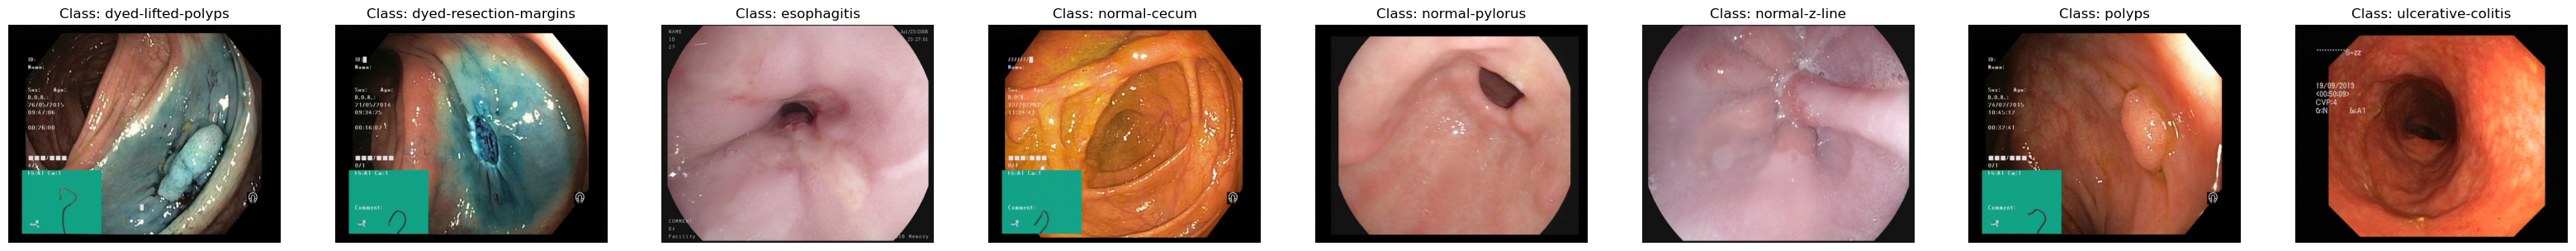

In [9]:
representative_images = train_df.groupby('targets').first().reset_index()
image_paths = representative_images['file_paths'].tolist()
image_targets = representative_images['target_names'].tolist()
import matplotlib.pyplot as plt
import cv2

fig, axes = plt.subplots(1, len(image_paths), figsize=(40, 10))

for ax, img_path, target in zip(axes, image_paths, image_targets):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(f'Class: {target}')
    ax.axis('off')

plt.show()


## 3-1. 데이터프레임 Image 전처리 (applications = mobilent)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/project01-02/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=8,
    mode='min'
)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess_input  # 수정된 임포트



import albumentations as A

IMAGE_SIZE = 64
BATCH_SIZE = 64

train_generator = ImageDataGenerator(preprocessing_function=mobilenet_preprocess_input)
validation_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

train_flow = train_generator.flow_from_dataframe(dataframe=train_df,
                                                 x_col = 'file_paths', 
                                                 y_col = 'target_names',
                                                 target_size= (IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_flow = validation_generator.flow_from_dataframe(dataframe=validation_df,
                                                 x_col = 'file_paths', 
                                                 y_col = 'target_names',
                                                 target_size= (IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='categorical',
                                                 )

test_flow = test_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col = 'file_paths', 
                                                 y_col = 'target_names',
                                                 target_size= (IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='categorical',
                                                 )

print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)


Found 2560 validated image filenames belonging to 8 classes.
Found 640 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.
{'dyed-lifted-polyps': 0, 'dyed-resection-margins': 1, 'esophagitis': 2, 'normal-cecum': 3, 'normal-pylorus': 4, 'normal-z-line': 5, 'polyps': 6, 'ulcerative-colitis': 7}
{'dyed-lifted-polyps': 0, 'dyed-resection-margins': 1, 'esophagitis': 2, 'normal-cecum': 3, 'normal-pylorus': 4, 'normal-z-line': 5, 'polyps': 6, 'ulcerative-colitis': 7}
{'dyed-lifted-polyps': 0, 'dyed-resection-margins': 1, 'esophagitis': 2, 'normal-cecum': 3, 'normal-pylorus': 4, 'normal-z-line': 5, 'polyps': 6, 'ulcerative-colitis': 7}


In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

IMAGE_SIZE = 64

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(8, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
import gc

gc.collect()
model = create_model(model_name='mobilenet', verbose=True)
model.compile(optimizer=Adam(), loss= CategoricalCrossentropy(), metrics = ['acc'])

/var/folders/f7/gl6wpvqx5z596rbpjsq5n3tc0000gn/T/ipykernel_50586/13343419.py:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 2,322,442 (8.86 MB)

 Trainable params: 2,288,330 (8.73 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 16

history = model.fit(train_flow,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_flow,
                    callbacks=[mcp_cb, rlr_cb, ely_cb])